In [160]:
import torch
import torch.nn as nn
from torchvision import models, transforms
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import os
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

In [161]:
# Image transformations
normal_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224 pixels
    transforms.ToTensor(),  # Convert to PyTorch Tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalization
])

mirror_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224 pixels
    transforms.RandomHorizontalFlip(p=1), # Make a mirror image, should perfect fit the golf swing case as lefty become righty and vice versa
    transforms.ToTensor(),  # Convert to PyTorch Tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalization
])

pad_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224 pixels
    transforms.Pad(padding=10, fill=0, padding_mode='constant'), # Adds padding to the edges of the image
    transforms.ToTensor(),  # Convert to PyTorch Tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalization
])

# Video dataset class: a single video dataset would consist 9 sequence of frames with highlighted skeleton points and
# white/original background
class VideoDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.videos = []
        curr_vid_id = '0'
        curr_vid_list = []
        for c in self.classes:
            # somehow it reads the Mac .DS_store file...
            if c.startswith('.'):
                continue

            pro_am, vid_id, swing_pos, confidence_score, _ = c.split('_')
            # confidence_score = confidence_score[:-4]

            if vid_id == curr_vid_id:
                curr_vid_list.append((vid_id, swing_pos, float(confidence_score), pro_am, os.path.join(root_dir, c)))
            else:
                if len(curr_vid_list) != 0:
                    self.videos.append(list(curr_vid_list))
                curr_vid_id = vid_id
                curr_vid_list.clear()
                curr_vid_list.append((vid_id, swing_pos, float(confidence_score), pro_am, os.path.join(root_dir, c)))

        if len(curr_vid_list) != 0:
            self.videos.append(list(curr_vid_list))

    def __len__(self):
        return len(self.videos)

    def __getitem__(self, idx):
        frames = []
        for frame in self.videos[idx]:
            vid_id, swing_position, confidence_score, pro_am, img_path = frame
            img = Image.open(img_path)
            if self.transform:
                img = self.transform(img)
            frames.append(img)

        # Stack frames into one tensor
        # TODO: figure out a way to encode swing_position & confidence score
        video = torch.hstack(frames)
        label = 1 if (pro_am == 'pro') else 0
        return video, label

In [162]:
# currently using 3D skeleton points w/ white background as training examples
positive_dir = '../ai_golf_swing_dataset/pro_swing-position_skeleton_white-background_frames'
negative_dir = '../ai_golf_swing_dataset/amateur_swing-position_skeleton_white-background_frames'
positive_dataset = VideoDataset(positive_dir, normal_transform) # size 1400
negative_dataset = VideoDataset(negative_dir, normal_transform) # size 500
negative_dataset_mirror = VideoDataset(negative_dir, mirror_transform) # size 500
negative_dataset_pad = VideoDataset(negative_dir, pad_transform) # size 500
size = int(len(negative_dataset_pad) * 4/5)
subset1, subset2 = random_split(negative_dataset_pad, [size, len(negative_dataset_pad) - size])

# Collect positive data set (1400 original) and negative dataset (500 original + 500 mirror + 400 pad) in a balanced way
full_dataset = torch.utils.data.ConcatDataset([positive_dataset, negative_dataset, negative_dataset_mirror])

# Split the data into training and validation
# 70% train, 20% dev, 10% test
train_size = int(0.7 * len(full_dataset))
val_size = int(0.2 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size, test_size])

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)

# Load pre-trained model
# model = models.resnet50(pretrained=True)
model = models.densenet121(pretrained=True)

# Freeze the model parameters
for param in model.parameters():
    param.requires_grad = False

# Replace the final layer for binary classification
num_features = model.classifier.in_features
model.classifier = nn.Linear(num_features, 1)


# Use GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


/Users/zihan.yi/opt/anaconda3/envs/openmmlab/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/zihan.yi/opt/anaconda3/envs/openmmlab/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


train-0: 100%|██████████| 108/108 [07:33<00:00,  4.20s/it]


Epoch:  0 Training Loss:  52.4517240524292 , Training Acc:  0.804410911201393
Finishing Training the model. Now starting to evaluate...


validation: 100%|██████████| 31/31 [01:52<00:00,  3.64s/it]

Dev Set Acc:  0.9369918699186992
Dev Set F1 score:  0.9437386569872959


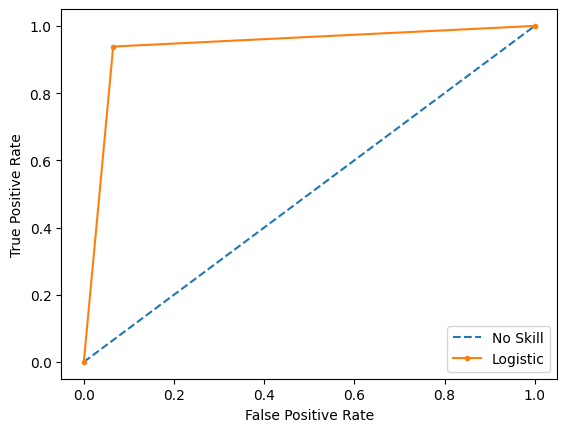

AUC: 0.937


train-1: 100%|██████████| 108/108 [07:29<00:00,  4.16s/it]


Epoch:  1 Training Loss:  38.22729739546776 , Training Acc:  0.8723157283807312
Finishing Training the model. Now starting to evaluate...


validation: 100%|██████████| 31/31 [01:50<00:00,  3.56s/it]

Dev Set Acc:  0.9471544715447154
Dev Set F1 score:  0.9530685920577617


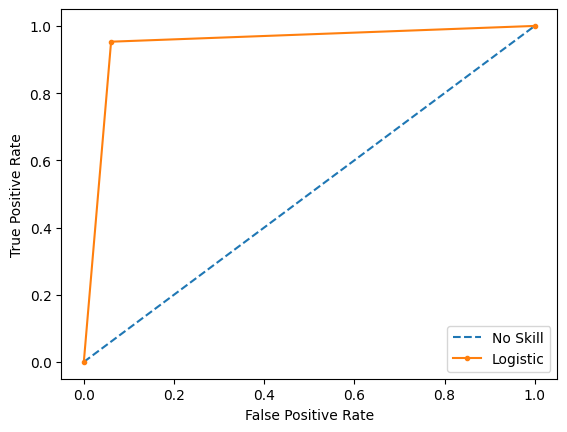

AUC: 0.946


train-2: 100%|██████████| 108/108 [07:22<00:00,  4.09s/it]


Epoch:  2 Training Loss:  32.81670816987753 , Training Acc:  0.8914683691236216
Finishing Training the model. Now starting to evaluate...


validation: 100%|██████████| 31/31 [01:51<00:00,  3.61s/it]

Dev Set Acc:  0.9349593495934959
Dev Set F1 score:  0.9450171821305843


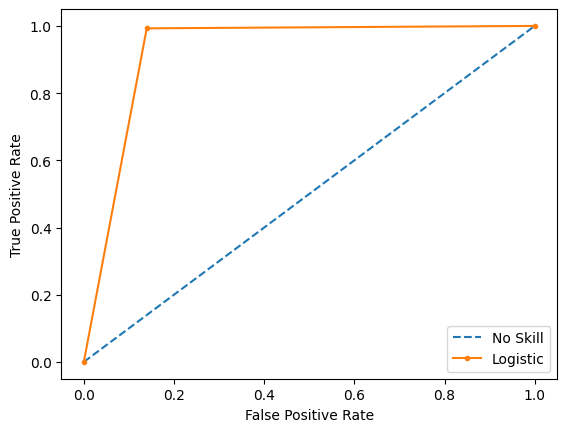

AUC: 0.927


train-3: 100%|██████████| 108/108 [07:36<00:00,  4.23s/it]


Epoch:  3 Training Loss:  29.84801296144724 , Training Acc:  0.9164248403946604
Finishing Training the model. Now starting to evaluate...


validation: 100%|██████████| 31/31 [01:49<00:00,  3.54s/it]

Dev Set Acc:  0.9532520325203252
Dev Set F1 score:  0.9598603839441535


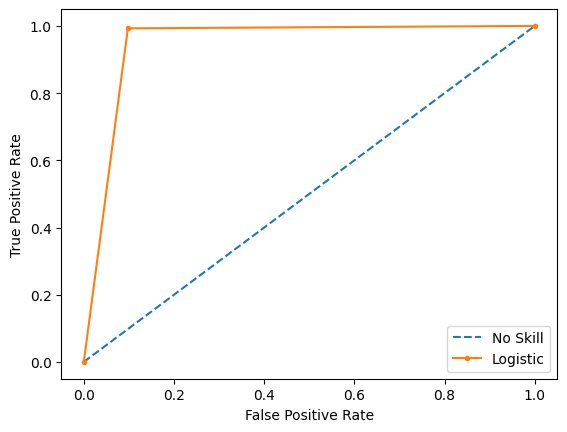

AUC: 0.948


train-4: 100%|██████████| 108/108 [07:29<00:00,  4.16s/it]


Epoch:  4 Training Loss:  27.343413569033146 , Training Acc:  0.9257109692396982
Finishing Training the model. Now starting to evaluate...


validation: 100%|██████████| 31/31 [01:53<00:00,  3.67s/it]

Dev Set Acc:  0.9532520325203252
Dev Set F1 score:  0.9597197898423818


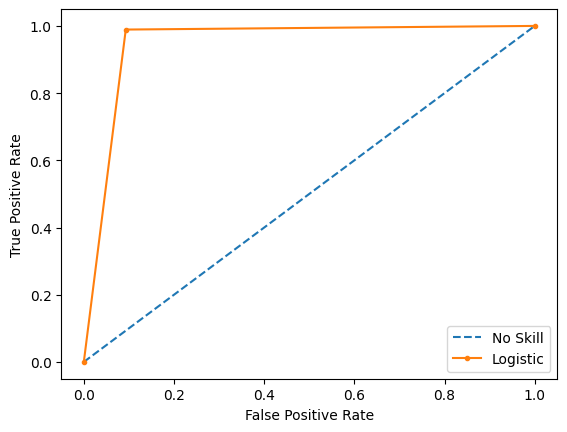

AUC: 0.948


train-5: 100%|██████████| 108/108 [07:48<00:00,  4.34s/it]


Epoch:  5 Training Loss:  24.41947078704834 , Training Acc:  0.942542077771329
Finishing Training the model. Now starting to evaluate...


validation: 100%|██████████| 31/31 [01:57<00:00,  3.80s/it]

Dev Set Acc:  0.9552845528455285
Dev Set F1 score:  0.9614035087719298


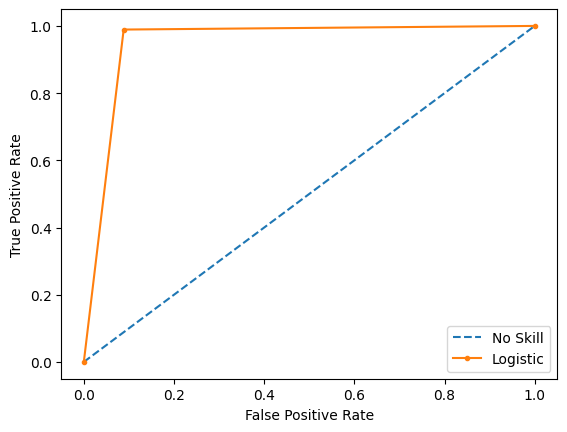

AUC: 0.950


train-6: 100%|██████████| 108/108 [07:38<00:00,  4.25s/it]


Epoch:  6 Training Loss:  24.35065697133541 , Training Acc:  0.9355774811375508
Finishing Training the model. Now starting to evaluate...


validation: 100%|██████████| 31/31 [01:52<00:00,  3.64s/it]

Dev Set Acc:  0.959349593495935
Dev Set F1 score:  0.9645390070921986


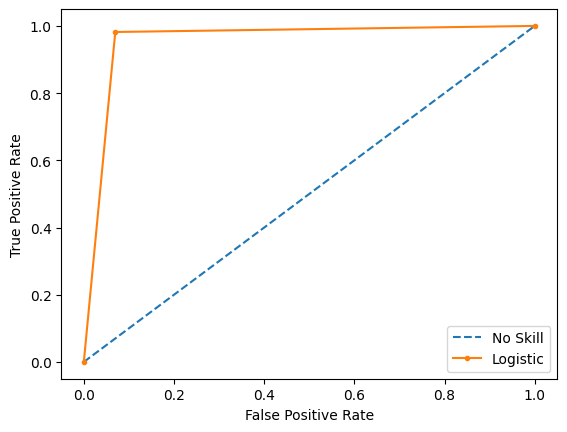

AUC: 0.956


train-7: 100%|██████████| 108/108 [07:31<00:00,  4.18s/it]


Epoch:  7 Training Loss:  24.439784564077854 , Training Acc:  0.9286128845037724
Finishing Training the model. Now starting to evaluate...


validation: 100%|██████████| 31/31 [01:53<00:00,  3.65s/it]

Dev Set Acc:  0.959349593495935
Dev Set F1 score:  0.9645390070921986


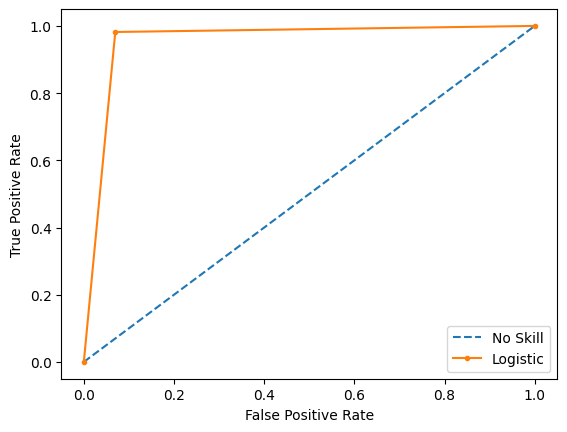

AUC: 0.956


train-8: 100%|██████████| 108/108 [07:35<00:00,  4.22s/it]


Epoch:  8 Training Loss:  22.08264933526516 , Training Acc:  0.9442832269297736
Finishing Training the model. Now starting to evaluate...


validation: 100%|██████████| 31/31 [01:52<00:00,  3.63s/it]

Dev Set Acc:  0.9532520325203252
Dev Set F1 score:  0.9588550983899822


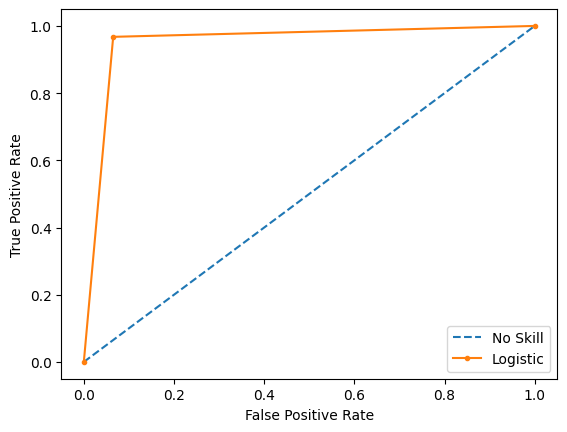

AUC: 0.951


train-9: 100%|██████████| 108/108 [07:35<00:00,  4.22s/it]


Epoch:  9 Training Loss:  21.781441546976566 , Training Acc:  0.9413813116656994
Finishing Training the model. Now starting to evaluate...


validation: 100%|██████████| 31/31 [01:53<00:00,  3.65s/it]

Dev Set Acc:  0.9552845528455285
Dev Set F1 score:  0.9615384615384615


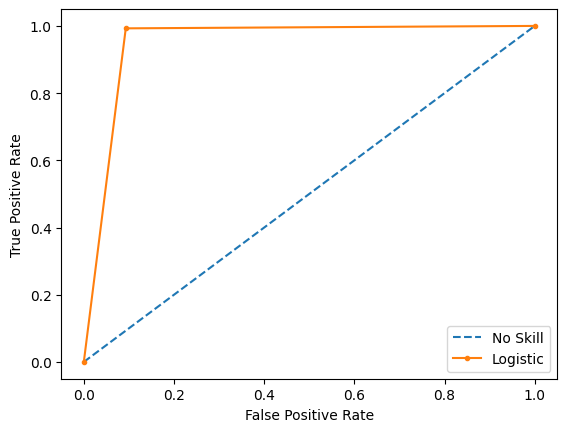

AUC: 0.950
Overall Best Dev Acc:  0.959349593495935


In [163]:
best_dev_acc = 0.0
best_model = None

TRAINING_EPOCH = 10
# threshold probs for classifier to predict true
threshold = 0.5

# Train the model
training_loss_history = []
training_acc_list = []
val_acc_list = []
for epoch in range(TRAINING_EPOCH):  # for 10 epochs

    # Train mode
    model.train()
    train_loss = 0.0
    y_train_true = []
    y_train_pred = []
    for inputs, labels in tqdm(train_dataloader, desc=f'train-{epoch}', disable=False):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs.view(-1), labels.float())

        probs = torch.sigmoid(outputs)
        preds = (probs > threshold).int().reshape(labels.shape)
        y_train_true.extend(labels.tolist())
        y_train_pred.extend(preds.tolist())

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_acc = accuracy_score(y_train_true, y_train_pred)
    training_loss_history.append(train_loss)
    training_acc_list.append(train_acc)
    print('Epoch: ', epoch, 'Training Loss: ', train_loss, ', Training Acc: ', train_acc)
    print('Finishing Training the model. Now starting to evaluate...')

    # Validate the model
    model.eval()  # Set the model to evaluation mode

    y_val_true = []
    y_val_pred = []
    with torch.no_grad():
        for inputs, labels in tqdm(val_dataloader, desc=f'validation', disable=False):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            probs = torch.sigmoid(outputs)
            preds = (probs > threshold).int().reshape(labels.shape)
            y_val_true.extend(labels.tolist())
            y_val_pred.extend(preds.tolist())

    f1 = f1_score(y_val_true, y_val_pred, average='binary')
    val_acc = accuracy_score(y_val_true, y_val_pred)
    val_acc_list.append(val_acc)

    print('Dev Set Acc: ', val_acc)
    print('Dev Set F1 score: ', f1)

    # calculate roc curves
    fpr, tpr, thresholds = roc_curve(y_val_true, y_val_pred)

    # plot the roc curve for the model
    plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, marker='.', label='Logistic')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

    # compute AUC score
    auc = roc_auc_score(y_val_true, y_val_pred)
    print('AUC: %.3f' % auc)

    if val_acc > best_dev_acc:
        best_dev_acc = val_acc
        best_model = 'skeleton-points-white-background_classifier_epoch_{}.pth'.format(epoch)
        # Save the curr best model
        torch.save(model.state_dict(), best_model)

print('Overall Best Dev Acc: ', best_dev_acc)

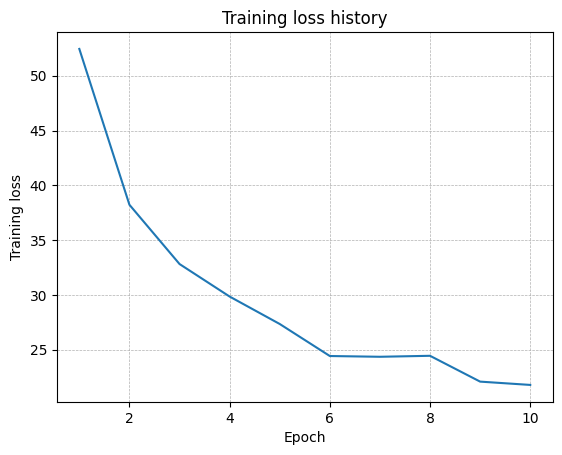

In [164]:
# TODO: training loss vs. epoch curve
plt.plot(list(range(1, 11)), training_loss_history)
plt.title("Training loss history")
plt.xlabel("Epoch")
plt.ylabel("Training loss")
plt.grid(linestyle='--', linewidth=0.5)
plt.show()

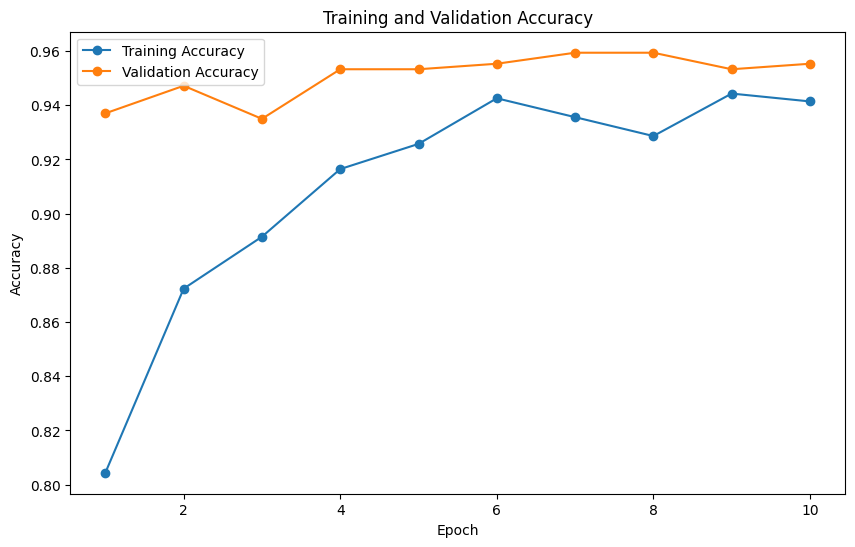

In [165]:
# TODO: training acc + dev set acc vs. epoch
plt.figure(figsize=(10, 6))

# Plot training accuracy
plt.plot(list(range(1, 11)), training_acc_list, label='Training Accuracy', marker='o')

# Plot validation accuracy
plt.plot(list(range(1, 11)), val_acc_list, label='Validation Accuracy', marker='o')

# Label axes and title
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Show legend to differentiate the lines
plt.legend()

# Display the plot
plt.show()

In [166]:
# test set validation
# best_model = 'pro_am_classifier_epoch_2.pth'

print('Starting to evaluate test set...')

print('Loading existing best model ', best_model)

# Load pre-trained model
# model = models.resnet50(pretrained=True)
model = models.densenet121(pretrained=True)

# Freeze the model parameters
for param in model.parameters():
    param.requires_grad = False

# Replace the final layer for binary classification
# model.fc = nn.Linear(model.fc.in_features, 1)
num_features = model.classifier.in_features
model.classifier = nn.Linear(num_features, 1)

model.load_state_dict(torch.load(best_model))
model.to(device)
model.eval()  # Set the model to evaluation mode

# threshold probs for classifier to predict true
threshold = 0.5

y_val_true = []
y_val_pred = []
with torch.no_grad():
    for inputs, labels in tqdm(test_dataloader, desc=f'test', disable=False):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        probs = torch.sigmoid(outputs)
        preds = (probs > threshold).int().reshape(labels.shape)
        y_val_true.extend(labels.tolist())
        y_val_pred.extend(preds.tolist())

    print('Test set accuracy: ', accuracy_score(y_val_true, y_val_pred))

Starting to evaluate test set...
Loading existing best model  skeleton-points-white-background_classifier_epoch_6.pth


/Users/zihan.yi/opt/anaconda3/envs/openmmlab/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/zihan.yi/opt/anaconda3/envs/openmmlab/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
test: 100%|██████████| 16/16 [00:56<00:00,  3.55s/it]

Test set accuracy:  0.9635627530364372


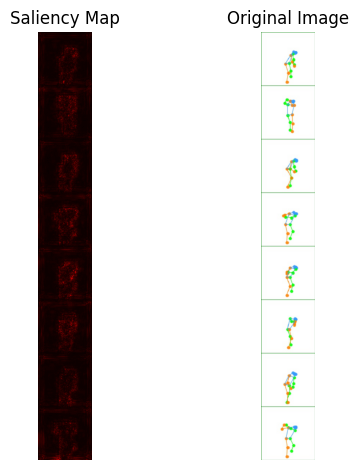

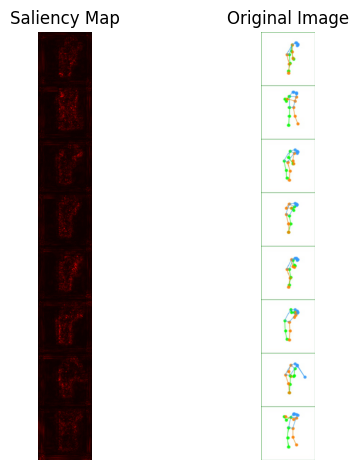

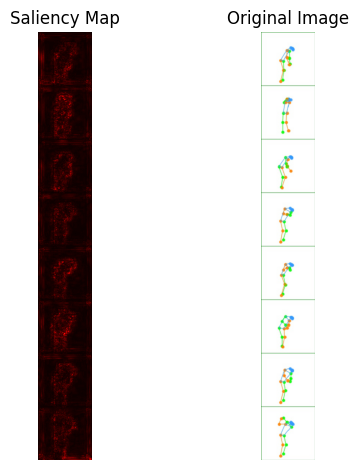

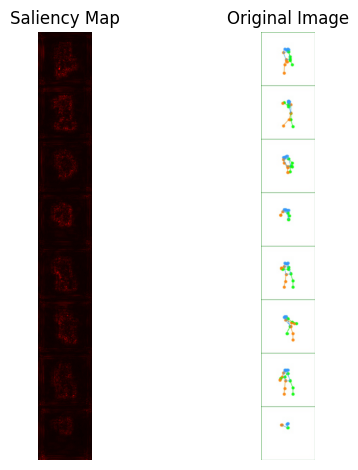

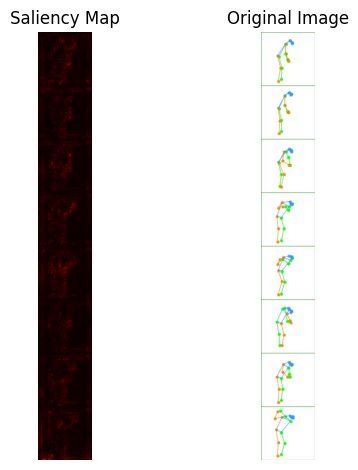

In [173]:
# Saliency Map
import numpy as np
saliency_data, _ = torch.utils.data.random_split(test_dataset, [5, len(test_dataset) - 5])
saliency_dataloader = DataLoader(saliency_data, batch_size=1)

inverse_transform = transforms.Compose([
    transforms.Normalize(mean=[0, 0, 0], std=[1 / 0.229, 1 / 0.224, 1 / 0.225]),
    transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1, 1, 1])
])

for inputs, labels in tqdm(saliency_dataloader, desc=f'test', disable=True):
    input_tensor = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)
    # Set the input tensor as a trainable variable
    input_tensor.requires_grad_(True)

    # Forward pass
    output = model(input_tensor)

    # Compute gradients
    model.zero_grad()
    output.backward()

    # Calculate the saliency map
    saliency_map = torch.abs(input_tensor.grad.squeeze(0))
    saliency_map = torch.mean(saliency_map, dim=0)

    # Normalize the saliency map (optional)
    saliency_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min())

    # Display or save the saliency map
    # Convert the tensor to a NumPy array

    input_tensor = inverse_transform(input_tensor)
    input_tensor = input_tensor.squeeze()
    image_array = torch.rot90(input_tensor, k=1, dims=(1, 2)).flip(dims=(1,))
    image_array = image_array.detach().numpy()

    image_array = image_array.transpose(2, 1, 0)

    fig, axs = plt.subplots(1, 2)

    # Plot the first image
    axs[0].imshow(saliency_map, cmap="hot")
    axs[0].set_title('Saliency Map')

    # Plot the second image
    axs[1].imshow(image_array)
    axs[1].set_title('Original Image')

    # Remove the axis labels
    for ax in axs:
        ax.axis('off')

    # Adjust the layout
    plt.tight_layout()

    # Show the plot
    plt.show()